# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf


In [2]:
import cv2
from tensorflow import keras

# 2. Remove dodgy images

In [3]:
import cv2
import imghdr
import os

In [4]:
data_dir = 'data' 

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [18]:
import numpy as np
from matplotlib import pyplot as plt

ERROR! Session/line number was not unique in database. History logging moved to new session 163


Found 2940 images belonging to 2 classes.


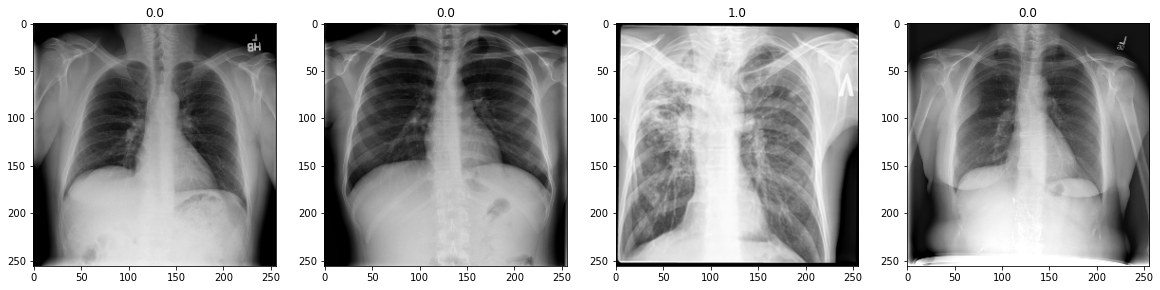

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Normalization is built into ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,brightness_range=[0.8, 1.2])  # Normalization happens here

data = datagen.flow_from_directory(
    'data',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)
batch = next(data)  # Returns (images, labels) as NumPy arrays
images, labels = batch

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(images[:4]):
    ax[idx].imshow(img)  # No .astype(int) needed!
    ax[idx].title.set_text(labels[idx])
plt.show()

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with normalization and validation split
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalizes pixel values to [0,1]
    validation_split=0.3,
    brightness_range=[0.8, 1.2]# 30% of data for validation
)

# Training generator (70% of data)
train = datagen.flow_from_directory(
    'data',                 # Directory path
    target_size=(256, 256), # Resizes all images
    batch_size=32,
    class_mode='binary',    # For binary classification
    subset='training',      # This is the key parameter
    shuffle=True           # Shuffles the data
)

# Validation generator (30% of data)
val = datagen.flow_from_directory(
    'data',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation',    # Automatically takes the validation split
    shuffle=False          # Typically don't shuffle validation data
)

# Verify the split
print(f"Found {train.samples} training images")
print(f"Found {val.samples} validation images")

Found 2059 images belonging to 2 classes.
Found 881 images belonging to 2 classes.
Found 2059 training images
Found 881 validation images


Found 1260 images belonging to 1 classes.


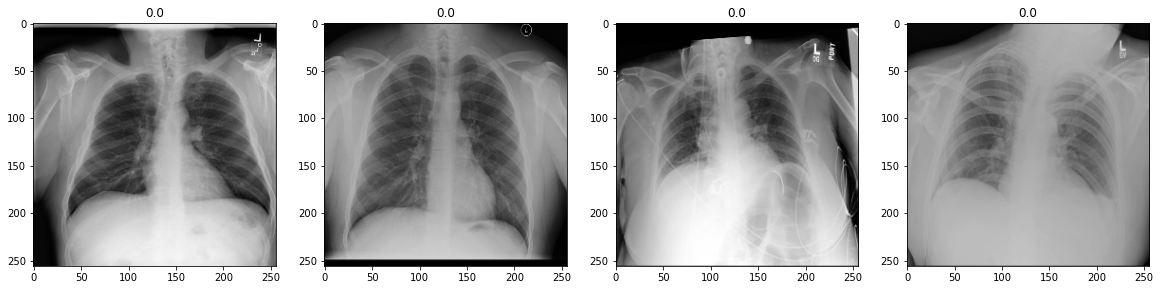

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Normalization is built into ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,brightness_range=[0.8, 1.2])  # Normalization happens here

test = datagen.flow_from_directory(
    'Test_Dataset_TB',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

# Get the next batch (equivalent to data.as_numpy_iterator().next())
batch = next(data)  # Returns (images, labels) as NumPy arrays
images, labels = batch

# Now you can use this with your visualization code:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(images[:4]):
    ax[idx].imshow(img)  # No .astype(int) needed!
    ax[idx].title.set_text(labels[idx])
plt.show()

# 6. Build Deep Learning Model

In [22]:
train

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [24]:
def create_tb_model(input_shape=(256, 256, 3)):
    model = Sequential([
        # First convolution block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Second convolution block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Third convolution block
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Fourth convolution block
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    
    return model

model = create_tb_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 256)      

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10),  # Changed from 'val_accuracy' to 'val_acc'
    ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5)  # Changed here too
]

# Train the model
hist = model.fit(
    train,
    steps_per_epoch=train.samples // 32,
    epochs=20,
    validation_data=val,
    validation_steps=val.samples // 32,
    callbacks= callbacks
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 64 steps, validate for 27 steps
Epoch 1/20
64/64 [==============================] - 26s 409ms/step - loss: 0.3741 - accuracy: 0.8411 - precision_2: 0.6324 - recall_2: 0.1265 - val_loss: 0.2329 - val_accuracy: 0.9074 - val_precision_2: 0.6763 - val_recall_2: 0.7287
Epoch 2/20
64/64 [==============================] - 25s 387ms/step - loss: 0.2168 - accuracy: 0.9077 - precision_2: 0.7899 - recall_2: 0.6042 - val_loss: 0.1974 - val_accuracy: 0.9213 - val_precision_2: 0.8506 - val_recall_2: 0.5736
Epoch 3/20
64/64 [==============================] - 23s 355ms/step - loss: 0.1741 - accuracy: 0.9255 - precision_2: 0.8358 - recall_2: 0.6836 - val_loss: 0.1674 - val_accuracy: 0.9282 - val_precision_2: 0.7519 - val_recall_2: 0.7752
Epoch 4/20
64/64 [==============================] - 22s 351ms/step - loss: 0.1384 - accuracy: 0.9482 - precision_2: 0.8726 - recall_2: 0.8083 - val_loss: 0.1499 - val_accuracy: 0.9387 - val_precision_2: 0.8519 - val_recall_2: 0.7132
Epoch 5/20
64/64 [========

# 8. Plot Performance

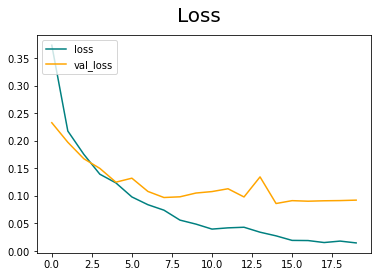

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 165


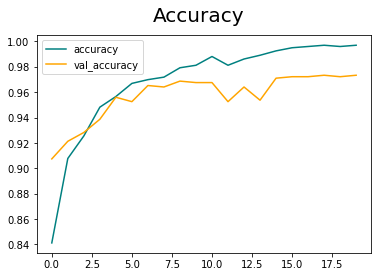

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [30]:
import numpy as np
from tensorflow.python.keras.metrics import Precision, Recall, Accuracy

# Initialize metrics
pre = Precision()
re = Recall()
acc = Accuracy()

test.reset()
for i in range(len(test)):
    X, y = next(test)
    yhat = model.predict(X)
    
    # Option 1: Squeeze predictions
    yhat = np.squeeze(yhat)
    
    # Option 2: Reshape labels
    # y = y.reshape(-1)
    
    # Threshold if needed (for binary classification)
    yhat = (yhat > 0.5).astype('int32')
    
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


In [31]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.83492064, shape=(), dtype=float32)


# 10. Test

In [32]:
import cv2

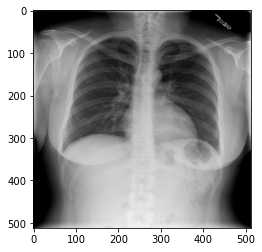

In [33]:
img = cv2.imread('TB_train_0016.png')
plt.imshow(img)
plt.show()

In [34]:
import tensorflow as tf
import numpy as np

# 1. Read the image file as bytes
with tf.io.gfile.GFile('TB_train_0016.png', 'rb') as f:
    img_bytes = f.read()

# 2. Decode the image (PNG in this case, not JPEG) and resize
img = tf.image.decode_png(img_bytes, channels=3)  # Use decode_png for .png files
resized_img = tf.image.resize(img, [256, 256])

# 3. Normalize and add batch dimension
normalized_img = resized_img / 255.0
batched_img = tf.expand_dims(normalized_img, axis=0)  # Shape: [1, 256, 256, 3]

# 4. Since TF2 runs eagerly by default, you can convert it to a NumPy array directly
img_for_pred = batched_img.numpy()

# Optionally, you can print the shape to verify
print("Preprocessed image shape:", img_for_pred.shape)


ERROR! Session/line number was not unique in database. History logging moved to new session 171
Preprocessed image shape: (1, 256, 256, 3)


In [35]:
# Make prediction
prediction = model.predict(img_for_pred)
print(prediction)
prob = prediction[0][0]
print("TB probability:" if prob > 0.5 else "Normal probability:", prob)

[[1.0142408e-09]]
Normal probability: 1.0142408e-09


# 11. Save the Model